## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. 

Необходимо проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [109]:
data = pd.read_csv('../data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


_______________________________________________________________________________________________________________

## **Задание 7.1.**

Начнем с исследования структуры наших данных.

In [110]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


Колонки таблицы с данными:
* **user_id** -	идентификатор пользователя, зашедшего на сайт;
* **date** - дата захода;
* **group** - группа теста (контрольная — А или тестовая — B);
* **purchase** - признак покупки: совершил ли пользователь покупку тура (1 — да, 0 — нет);
* **price** - цена купленного тура (если покупка не состоялась, цена равна 0);

В данных нет пропущенных значений.

Колонка **date** имеет тип данных object, следует преобразовать ее к datetime.
_______________________________________________________________________________________________________________

## **Задание 7.2.**

Приведем столбец date к типу данных datetime. Убедимся в равной длительности проведения тестирования для каждой из группы.


In [111]:
data['date'] = pd.to_datetime(data['date'])

date_intervals = data.groupby('group')['date'].agg(['min', 'max'])
date_intervals

,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


Можем убедиться, что тестирование производилось в одно и то же время, длительность тестирования обоих вариантов одинакова.

Интервал проведения тестов - около 3-х недель (с 02.01.2021 по 24.01.2021).
_______________________________________________________________________________________________________________

## **Задание 7.3.**

Проанализируем итоговые показатели в группах A и B:
* количество посещений сайта;
* суммарное количество покупок;
* сумма всех покупок.

In [112]:
data.groupby('group').agg({'user_id': 'count', 'purchase': 'sum', 'price': 'sum'})

,user_id,purchase,price
group,,,
A,147202,17723,1436260000
B,147276,17514,1554100000


По итоговым показателям в группах можем увидеть, что в группе B посещений сайта было немного больше, а покупок совершено меньше. Однако сумма покупок в группе B превышает сумму покупок в группе A.

По таким противоречивым данным пока рано делать какие-то выводы.
_______________________________________________________________________________________________________________

## **Задание 7.4.**

Проверим, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы.


In [113]:
A_users = set(data[data['group'] == 'A']['user_id'])
B_users = set(data[data['group'] == 'B']['user_id'])

common_users = A_users.intersection(B_users)
print(f'Количество пользователей, попавших в обе группы: {len(common_users)}')

Количество пользователей, попавших в обе группы: 1895


Так как нальзя определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. 

In [114]:
updated_data = data[data['user_id'].apply(lambda x: x not in common_users)]

_______________________________________________________________________________________________________________

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования получим итоговые данные по группам после преобразования таблицы.

In [115]:
total_data = updated_data.groupby('group', as_index=False).agg({'user_id': 'count', 'purchase': 'sum', 'price': 'sum'})
total_data.rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'}, inplace=True)
total_data

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Количество посещений обоих сайтов практически идентично (разница менее 0.05% от кол-ва в любой из групп).
Можем считать, что выборка сбалансирована.
Количество и суммы покупок также близки по значениям. Требуется дальнейший анализ для принятия решения о том, является ли разница значимой.
_______________________________________________________________________________________________________________

## **Задание 7.6.**

Рассчитаем конверсию и средний чек в группах  A и B

In [116]:
total_data['conversion'] = round(total_data['count_purchases']*100/total_data['count_visits'], 2)
total_data['mean_check '] = round(total_data['sum_price']/total_data['count_purchases'], 2)
total_data

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.03,81076.23
1,B,145381,17290,1533010000,11.89,88664.55


Как мы видели ранее, конверсия в группе A немного больше, но вариант B выглядит более эффективным по среднему чеку.
_______________________________________________________________________________________________________________

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [117]:
price_pivot = pd.pivot_table(data=updated_data[updated_data['price'] > 0], columns='price', index='group', values='purchase', aggfunc='sum')
price_pivot

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


Визуализируем полученную сводную таблицу с помощью тепловой карты. 

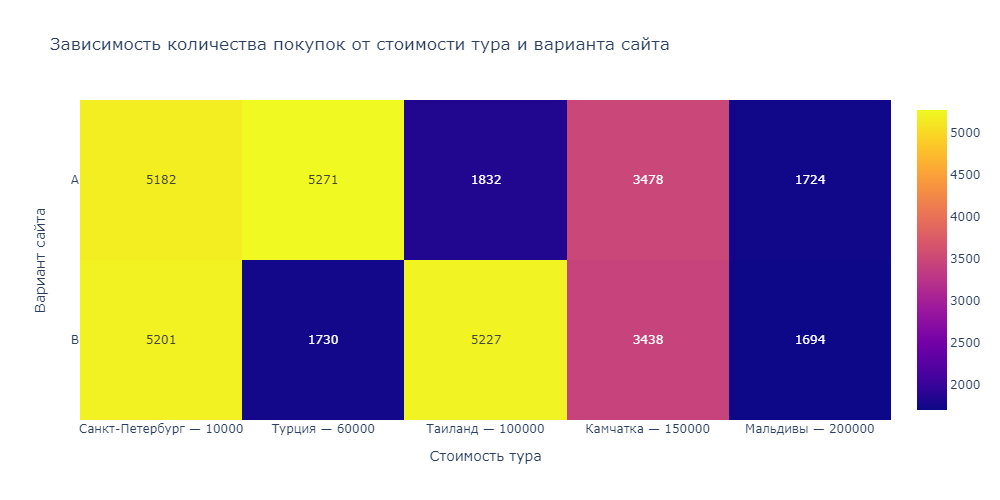

In [118]:
fig = px.imshow(
    price_pivot,
    text_auto=True,
    aspect="auto",
    title='Зависимость количества покупок от стоимости тура и варианта сайта',
    width=1000,
    labels={'x': 'Стоимость тура', 'y': 'Вариант сайта'},
    x=['Санкт-Петербург — 10000', 'Турция — 60000', 'Таиланд — 100000', 'Камчатка — 150000', 'Мальдивы — 200000']
)
fig.show('png')

На графике не наблюдаеся линейная зависимость количества покупок от стоимости туров. 
Например, дорогие туры на Мальдивы покупают реже, чем остальные туры. Однако чуть менее дорогой тур на Камчатку покупают чаще, чем туры в Тайланд в группе A и туры в Турцию в группе B.

Это наводит на мысль о том, что большое значение имеет не только стоимость, но и место назначения. Например, на Камчатку не требуется загранпаспорт. Возможно, это влияет на выбор. 

Количество покупок туров в Санкт-Петербург, на Камчатку и Мальдивы в обеих группах практически идентично.

Однако туры в Турцию гораздо чаще покупали пользователи группы A, а в Тайланд пользователи группы B. Возможно, покупательская способность пользователей группы B по каким-то причинам выше. А, возможно, туры в Турцию и Тайланд по-разному представлены в разных версиях сайтов, и в варианте B тур в Тайланд кажется более привлекательным, чем в Турцию. 
_______________________________________________________________________________________________________________

## **Задание 7.8.**

Построим таблицу с ежедневными данными результатов проведения A/B-тестирования.

In [119]:
daily_data = updated_data.groupby(['date', 'group'], as_index=False).agg({'user_id': 'count', 'purchase': 'sum', 'price': 'sum'})
daily_data.rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'}, inplace=True)
daily_data['conversion'] = round(daily_data['count_purchases']*100/daily_data['count_visits'], 2)
daily_data['mean_check'] = round(daily_data['sum_price']/daily_data['count_purchases'], 2)
daily_data.head()

,date,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,2021-01-02,A,2854,359,29410000,12.58,81922.01
1,2021-01-02,B,2861,345,29660000,12.06,85971.01
2,2021-01-03,A,6596,748,62000000,11.34,82887.70
3,2021-01-03,B,6619,754,65960000,11.39,87480.11
4,2021-01-04,A,6566,799,64250000,12.17,80413.02


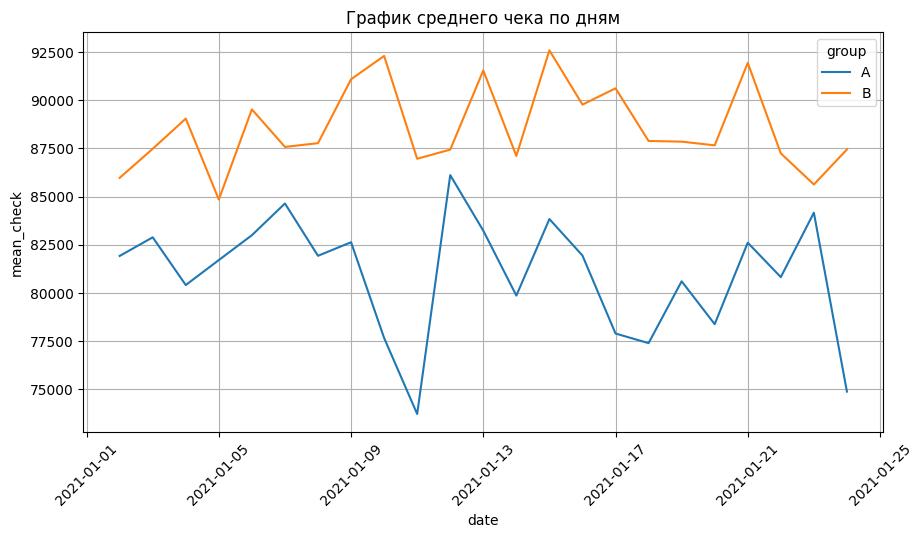

In [120]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для среднего чека во времени в каждой группе
sns.lineplot(
    data=daily_data,
    x='date',
    y='mean_check',
    hue='group', 
    ax=ax
)
ax.set_title('График среднего чека по дням')
ax.xaxis.set_tick_params(rotation=45)
ax.grid();

Даже до расчета кумулятивных показателей на графике видно, что ежедневный средний чек стабильно выше в группе B

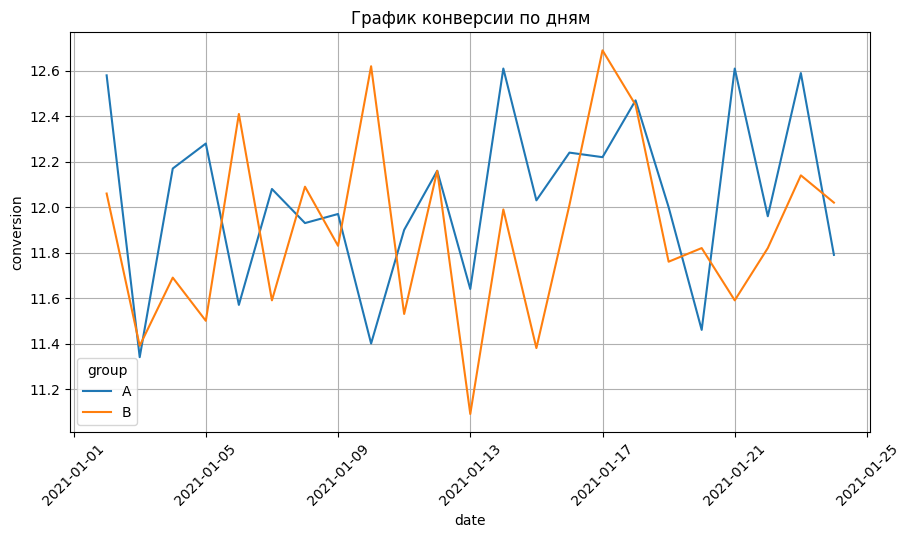

In [121]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для конверсии во времени в каждой группе
sns.lineplot(
    data=daily_data,
    x='date',
    y='conversion',
    hue='group', 
    ax=ax
)
ax.set_title('График конверсии по дням')
ax.xaxis.set_tick_params(rotation=45)
ax.grid();

А вот конверсия "скачет", нет очевидного лидера.
Требуется проанализировать кумулятивную конверсию.
_______________________________________________________________________________________________________________

## **Задание 7.9.** 

Рассчитаем кумулятивные показатели

In [122]:
daily_data['cum_count_visits'] = daily_data.groupby(['group'])['count_visits'].cumsum()
daily_data['cum_count_purchases'] = daily_data.groupby(['group'])['count_purchases'].cumsum()
daily_data['cum_sum_price'] = daily_data.groupby(['group'])['sum_price'].cumsum()

daily_data['cum_conversion'] = round(daily_data['cum_count_purchases']*100/daily_data['cum_count_visits'], 2)
daily_data['cum_mean_check'] = round(daily_data['cum_sum_price']/daily_data['cum_count_purchases'], 2)
display(daily_data.head())

,date,group,count_visits,count_purchases,sum_price,conversion,mean_check,cum_count_visits,cum_count_purchases,cum_sum_price,cum_conversion,cum_mean_check
0,2021-01-02,A,2854,359,29410000,12.58,81922.01,2854,359,29410000,12.58,81922.01
1,2021-01-02,B,2861,345,29660000,12.06,85971.01,2861,345,29660000,12.06,85971.01
2,2021-01-03,A,6596,748,62000000,11.34,82887.70,9450,1107,91410000,11.71,82574.53
3,2021-01-03,B,6619,754,65960000,11.39,87480.11,9480,1099,95620000,11.59,87006.37
4,2021-01-04,A,6566,799,64250000,12.17,80413.02,16016,1906,155660000,11.90,81668.42


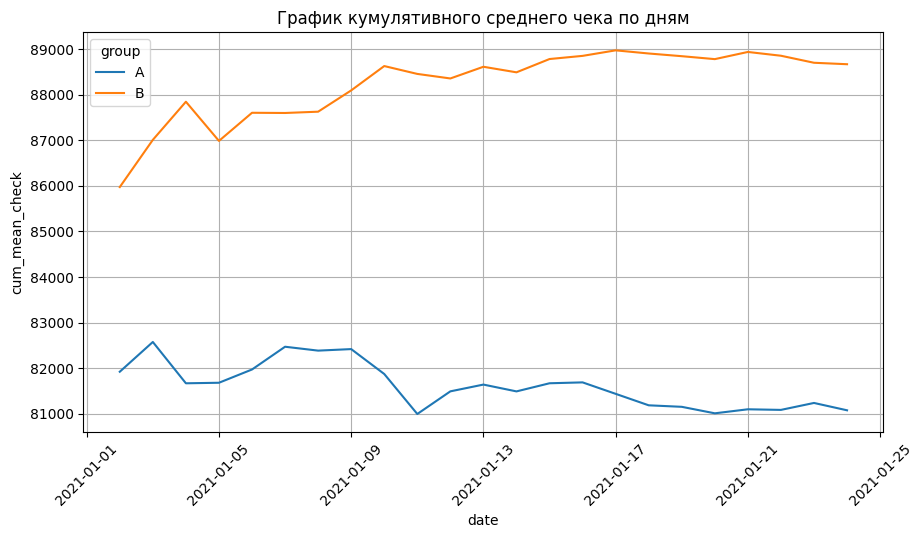

In [123]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивного среднего чека во времени в каждой группе
sns.lineplot(
    data=daily_data,
    x='date',
    y='cum_mean_check',
    hue='group', 
    ax=ax
)
ax.set_title('График кумулятивного среднего чека по дням')
ax.xaxis.set_tick_params(rotation=45)
ax.grid();

После 2021-01-11 скачки среднего чека прекратились. Средний чек группы A стабильно хуже среднего чека группы B на всём промежутке времени. 

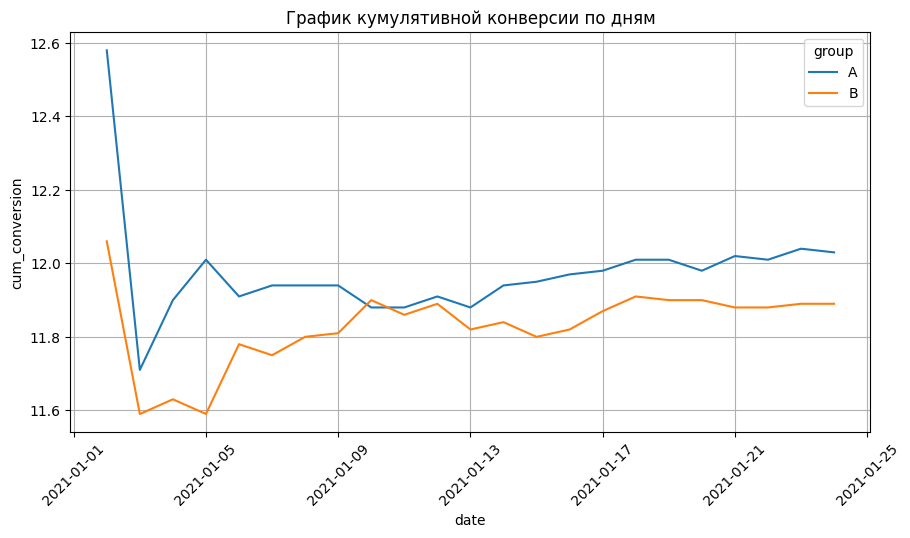

In [124]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(
    data=daily_data,
    x='date',
    y='cum_conversion',
    hue='group', 
    ax=ax
)
ax.set_title('График кумулятивной конверсии по дням')
ax.xaxis.set_tick_params(rotation=45)
ax.grid();

После 2021-01-11 скачки конверсии прекратились. Судя по графику, конверсия группы B хуже конверсии группы A. 

На основании стабилизированного кумулятивного графика мы можем сделать вывод, что длительность эксперимента была достаточной для того, чтобы судить о статистической значимости разности между показателями в группах.
_______________________________________________________________________________________________________________

## **Задание 7.10.**

Проверим статистическую значимость разницы между конверсией в группах.
По графикам кажется, что конверсия в группе A выше. Проверим это.

Для проверки гипотезы равенства пропорций мы можем воспользоваться уже знакомым нам z-критерием для пропорций

In [125]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=total_data['count_purchases'], #число "успехов"
    nobs=total_data['count_visits'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Мы не нашли статистически значимой разницы между конверсиями в группах A и B
_______________________________________________________________________________________________________________

## **Задание 7.11.**

Построим 95%-ый доверительный интервал для конверсий и разницы между ними.

In [126]:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    result = []
    for index in range(len(n)):
        x_p_current =  x_p[index]
        eps = z_crit * (x_p_current * (1 - x_p_current) / n[index]) ** 0.5 #погрешность
        lower_bound = x_p_current - eps # левая (нижняя) граница
        upper_bound = x_p_current + eps # правая (верхняя) граница
        result.append((round(lower_bound * 100, 2), round(upper_bound * 100, 2)))
    return result

In [127]:
conf_intervals = proportions_conf_interval(
n=total_data['count_visits'], # размер выборки
x_p=total_data['count_purchases']/total_data['count_visits'] # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_intervals[0]))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_intervals[1]))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


Доверительные интервалы конверсий групп пересекаются. Это значит, что существует вероятность, что истинное значение конверсии в обеих группах может совпасть.

То есть мы не можем однозначно сказать, есть ли разница в конверсиях. Построим доверительный интервал разницы конверсий.

In [128]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

In [129]:
# размеры выборок групп А и B
n = total_data['count_visits']
# выборочная пропорция гру.пп A и B
xp = total_data['count_purchases']/total_data['count_visits']
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Построенный доверительный интервал с 95 %-ой надёжностью говорит нам, что разница в конверсии между вариантом B и вариантом А лежит в интервале от -0.38 % до 0.09 %. 

Отсюда можно сделать вывод, что статистической разницы в конверсии между вариантами А и B не существует, то есть они являются равнозначными по данной метрике.
_______________________________________________________________________________________________________________

## **Задание 7.12.**

Проверим гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

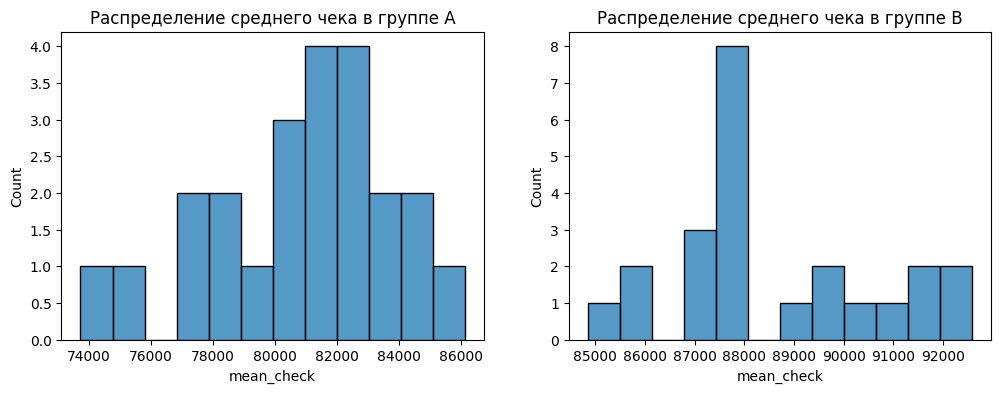

In [130]:
daily_data_a = daily_data[daily_data['group'] == 'A']
daily_data_b = daily_data[daily_data['group'] == 'B']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#строим гистограмму для среднего чека в каждой группе
sns.histplot(x='mean_check', data=daily_data_a, ax=axes[0], bins=12)
sns.histplot(x='mean_check', data=daily_data_b, ax=axes[1], bins=12)
#задаём названия графикам
axes[0].set_title('Распределение среднего чека в группе А');
axes[1].set_title('Распределение среднего чека в группе B');

Визуально распределение среднего чека в группе B нельзя однозначно назвать нормальным. Проверим это с помощью теста Шапиро-Уилка

In [131]:
from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(daily_data_a['mean_check'])
shapiro_result_b = shapiro(daily_data_b['mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))


p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


При уровне значимости 0.05 мы считаем, что распределение в обеих группах нормальное. 
_______________________________________________________________________________________________________________

## **Задание 7.13.**

Сравним варианты дизайна страницы по метрике среднего чека. 

Т.к. распределение в обеих группах нормадбное, мы можем использовать t-тест (объектов в выборке < 30 (23), групп 2, зависимый показатель количественный).

По графикам мы видели, что средний чек в группе B выше, чем в группе A.

Нулевая гипотеза: \
$H_0 : p_a = p_b$, то есть средний чек в группах А и B одинаков.

Альтернативная гипотеза: \
$H_1 : p_a < p_b$, то есть средний чек в группе А меньше, чем в группе B.

In [132]:
from scipy.stats import ttest_ind
# нулевая и альтернативная гипотезы
H0 = 'Средний чек в группах одинаков'
H1 = 'Средний чек в группе А меньше, чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=daily_data_a['mean_check'],
    b=daily_data_b['mean_check'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу. Средний чек в группах одинаков
Альтернативная гипотеза. H1: Средний чек в группе А меньше, чем в группе B


Видим статистически значимую разницу между средними чеками в группах. Вариант B эффективнее по этой метрике.
_______________________________________________________________________________________________________________

## **Задание 7.14.**

Построим 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используем  $t_{крит}$ в своих расчетах.

In [133]:
def conf_interval(x_mean, x_std, n, gamma=0.95):
    k = n - 1 # число степеней свободы
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, k) # t-критическое
    eps = t_crit * x_std/(n ** 0.5) # погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
    return confidence_interval

n_a = daily_data_a.shape[0] # размер выборки
n_b = daily_data_a.shape[0] # размер выборки
x_mean_a = daily_data_a['mean_check'].mean() # выборочное среднее
x_std_a = daily_data_a['mean_check'].std() # выборочное стандартное отклонение
x_mean_b = daily_data_b['mean_check'].mean() # выборочное среднее
x_std_b = daily_data_b['mean_check'].std() # выборочное стандартное отклонение

conf_interval_a = conf_interval(x_mean_a, x_std_a, n_a)
conf_interval_b = conf_interval(x_mean_b, x_std_b, n_b)

print('Доверительный интервал среднего чека группы A: {}'.format(conf_interval_a)) # выводим результат
print('Доверительный интервал среднего чека группы B: {}'.format(conf_interval_b)) # выводим результат

Доверительный интервал среднего чека группы A: (79630, 82308)
Доверительный интервал среднего чека группы B: (87626, 89526)


С 95% уверенностью можем сказать, что средний чек группы A лежит в интервале от 79630 до 82308 руб.
А средний чек группы B лежит в интервале от 87626 до 89526 руб.

Доверительные интервалы групп не пересекаются. Значит, средний чек группы B действительно больше среднего чека в группе A.
_______________________________________________________________________________________________________________

## **Общий вывод по результатам A/B-теста**

Второй вариант дизайна посадочной страницы (B) является более эффективным по метрике среднего чека, чем первый вариант (A).
По метрике конверсии мы считаем варианты идентичными.

Если затраты на внедрение обоих вариантов идентичны, то следует рекомендовать туристической компании использовать вариант B.  